In [1]:
import sys
sys.path.append("../")
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import torch
import torch.nn as nn
import numpy as np

from HyperSINDy import Net
from baseline import Trainer
from library_utils import Library
from Datasets import SyntheticDataset
from other import init_weights, make_folder, set_random_seed

from exp_utils import get_equations

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

sns.set()

In [2]:
def plot_samples(samples, num_samples=4, dpi=300, figsize=None, filename=None):    
    sns.set()

    # plotting code adopted partially from
    # https://www.tutorialspoint.com/how-to-hide-axes-but-keep-axis-labels-in-3d-plot-with-matplotlib
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
    else:
        fig = plt.figure(dpi=dpi)
    count = 0
    for i in range(len(samples)):
        sample_idx = 0
        for j in range(num_samples):
            ax = fig.add_subplot(3, num_samples, count + 1, projection='3d')
            curr_sample = samples[i][sample_idx]
            while np.any(np.isnan(curr_sample)):
                sample_idx += 1
                curr_sample = samples[i][sample_idx]
            ax.plot(curr_sample[:, 0], curr_sample[:, 1], curr_sample[:,2], color='red')

            ax.grid(False)
            color_tuple = (1.0, 1.0, 1.0, 0.0)
            ax.xaxis.set_pane_color(color_tuple)
            ax.yaxis.set_pane_color(color_tuple)
            ax.zaxis.set_pane_color(color_tuple)
            ax.xaxis.line.set_color(color_tuple)
            ax.yaxis.line.set_color(color_tuple)
            ax.zaxis.line.set_color(color_tuple)
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            #fig.subplots_adjust(hspace=-0.5, wspace=-0.075)
            sample_idx += 1
            count += 1
            
    fig.subplots_adjust(hspace=-0.7, wspace=-0.125)    

    if filename is not None:
        plt.savefig(filename + ".png", dpi=300)
    plt.show()
    plt.close()

In [3]:
# The simulation code here was adopted from:
# https://matplotlib.org/stable/gallery/mplot3d/lorenz_attractor.html

def lorenz(x, y, z, s, r, b, t, scale):
    s = np.random.normal(s, scale)

    r = np.random.normal(r, scale)
    r2 = np.random.normal(1, 0)
    r3 = np.random.normal(1, 0)

    b2 = np.random.normal(1, 0)
    b = np.random.normal(b, scale)

    x_dot = s * (y - x)
    y_dot = r * x - r2 * y - r3 * x * z
    z_dot = b2 * x * y - b * z
    
    return np.array([x_dot, y_dot, z_dot]), np.array([s, r, b])

def simulation(init_conds, steps, dt, s, r, b, scale):
    # Need one more for the initial values
    x = np.zeros([steps, len(init_conds)])
    dx = np.zeros([steps, len(init_conds)])
    ts = np.zeros([steps,])
    params = np.zeros([steps, 3])

    # Set initial values
    x[0] = init_conds

    # Step through "time", calculating the partial derivatives at the current
    # point and using them to estimate the next point
    for i in range(steps):
        x_dot, curr_params = lorenz(x[i][0], x[i][1], x[i][2], s, r, b, i * dt, scale)
        dx[i] = x_dot
        ts[i] = i * dt
        params[i] = curr_params
        if i == steps - 1:
            break
        x[i + 1] = x[i] + x_dot * dt
    return x

def get_samples(init_cond, steps, dt, s, r, b, scale, num_samples, z_dim):
    samples = np.zeros([num_samples, steps, z_dim])
    for i in range(num_samples):
        samples[i] = simulation(init_cond, steps, dt, s, r, b, scale)
    return samples

In [4]:
SEED = 123456

In [5]:
set_random_seed(SEED)

In [6]:
dt = 0.01
z_dim = 3
timesteps = 10000
x0 = (-1, 2, 0.5)
scales = [1, 5, 10]
samples = [get_samples(x0, timesteps, dt, 10, 28, 8.0 / 3, scale, 20, z_dim) for scale in scales]

/tmp/ipykernel_2115070/602245172.py:16: RuntimeWarning: overflow encountered in scalar multiply
  z_dot = b2 * x * y - b * z
/tmp/ipykernel_2115070/602245172.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  z_dot = b2 * x * y - b * z
/tmp/ipykernel_2115070/602245172.py:15: RuntimeWarning: overflow encountered in scalar multiply
  y_dot = r * x - r2 * y - r3 * x * z
/tmp/ipykernel_2115070/602245172.py:39: RuntimeWarning: invalid value encountered in add
  x[i + 1] = x[i] + x_dot * dt
/tmp/ipykernel_2115070/602245172.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  y_dot = r * x - r2 * y - r3 * x * z


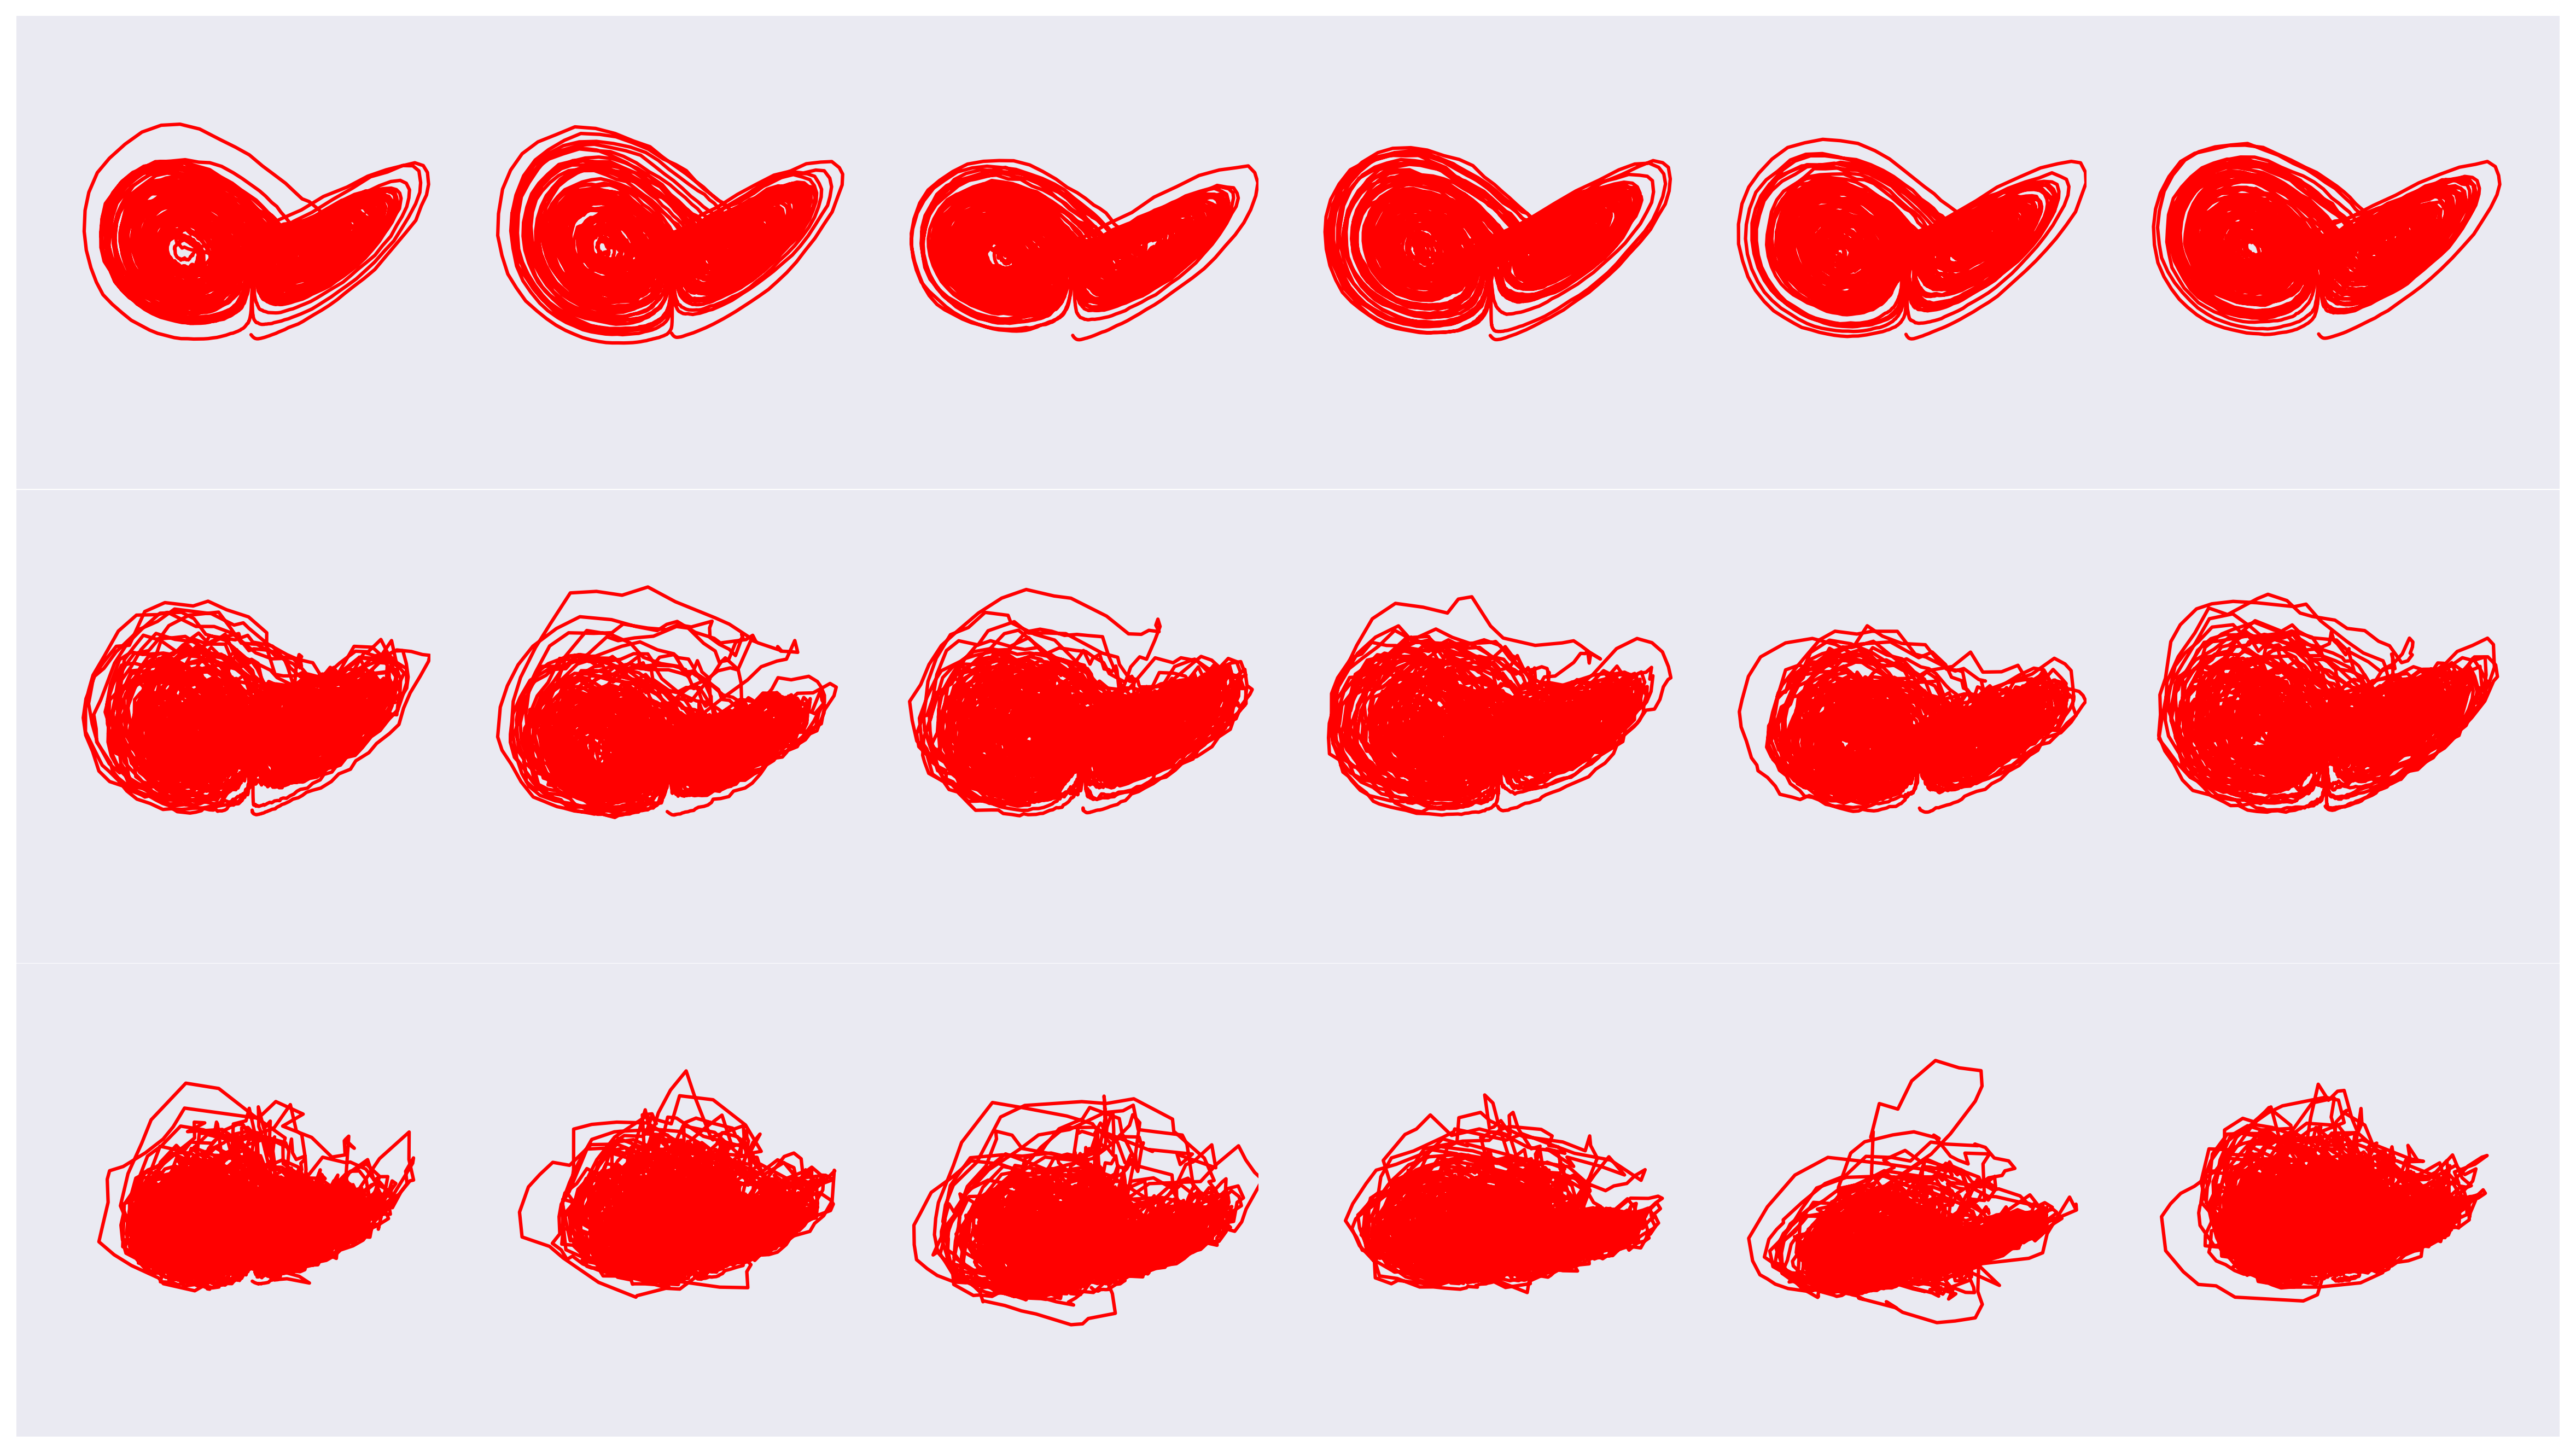

In [7]:
#plot_samples(samples, 6, 300, (20, 20), None)
plot_samples(samples, 6, 300, (20, 20), "../results/app_lorenz_true")